In [1]:
%matplotlib widget

import numpy as np
import scipy
import matplotlib.pyplot as plt

from receiver import ReceiverBLE, Receiver802154
from filters import simple_squelch, add_white_gaussian_noise
from demodulation import demodulate_frequency, symbol_sync, binary_slicer
from data_io import read_iq_data
from visualisation import plot_complex_time, plot_periodograms

# Testing matched filtering on demodulation process

In [2]:
# Try custom demodulate() method from Receiver classes, where instead of using a low pass filter (with 200 taps!),
# a matched filter is used borrowed from the modulation process (use the same taps that are used for modulation)
# Evaluate the frequency response of the FIR taps (using periodogram plots!)
# Plot each step of the demodulation process within the demodulation() method (IQ time and periodogram)
# Once the matched filter is working properly try with additive noise (like examples in test_802154.ipynb)
# Evaluate how the differentiator works as a filter
# Understand why the null to null bandwidth of BLE is 1.5MHz, and for IEEE 802.15.4 is 3MHz

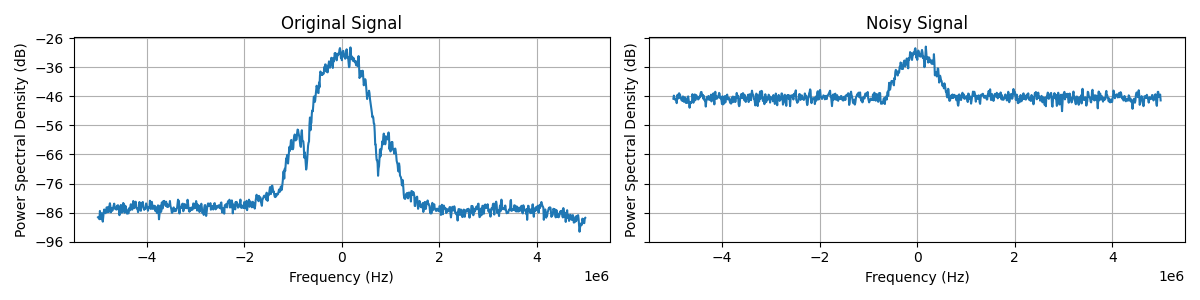

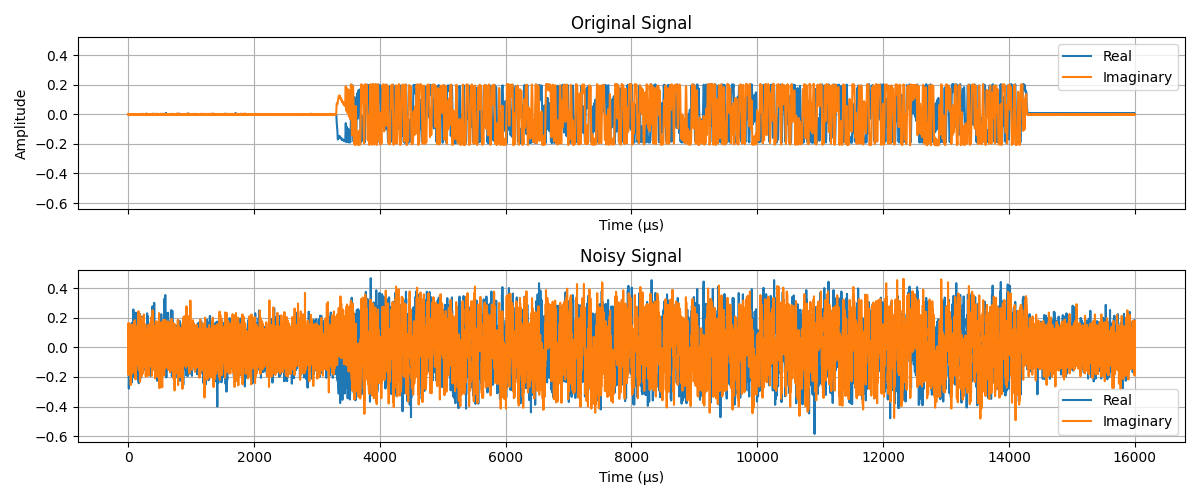

In [4]:
fs = 10e6  # Hz
filename = "BLE_0dBm.dat"  # Open BLE file
# filename = "802154_0dBm.dat"  # Open BLE file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")


noise_power = -15
noisy_iq_samples = add_white_gaussian_noise(iq_samples, noise_power)

# figsize = (12, 3)
plot_periodograms(
    [iq_samples, noisy_iq_samples], fs=fs, titles=["Original Signal", "Noisy Signal"], figsize=(12, 3), NFFT=1024
)
plot_complex_time([iq_samples, noisy_iq_samples], fs=fs, titles=["Original Signal", "Noisy Signal"], figsize=(12, 5))